In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/sample_submission.csv
/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/train.csv
/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/train.csv")
test = pd.read_csv("/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/test.csv")

In [7]:
train.head()


,timestamp,average_fare,rides_completed,driver_availability,surge_multiplier,vehicle_type,weather,traffic_index,special_event
0,2021-01-01 00:00:00,20.780423,457,49.170948,1.0,bike,Clear,63,0
1,2021-01-01 00:00:00,90.000000,80,30.000000,1.0,car,Clear,53,0
2,2021-01-01 00:00:00,41.197085,239,39.110219,1.0,auto,Clear,35,0
3,2021-01-01 01:00:00,20.772227,141,30.000000,1.5,bike,Stormy,83,0
4,2021-01-01 01:00:00,90.969805,98,30.000000,1.0,car,Clear,26,0


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
solution=pd.read_csv("/kaggle/input/solution/solution.csv")

In [8]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
missing_values = train.isnull().sum()
print("Missing values in each column:\n", missing_values)

train.dropna(inplace=True)

Missing values in each column:
 timestamp              0
average_fare           0
rides_completed        0
driver_availability    0
surge_multiplier       0
vehicle_type           0
weather                0
traffic_index          0
special_event          0
dtype: int64


In [9]:
# Load and pivot the data
average_fares = train.groupby(['timestamp', 'vehicle_type'])['average_fare'].mean().reset_index()
pivoted_fares = average_fares.pivot(index='timestamp', columns='vehicle_type', values='average_fare')

In [10]:
# Load the exogenous data (only weather)
exogenous_weather = train[['timestamp', 'weather']]

# One-hot encode the 'weather' variable
exogenous_weather_encoded = pd.get_dummies(
    exogenous_weather['weather'],
    drop_first=True,
    prefix='weather'
)

# Concatenate the timestamp with the encoded weather variables
exogenous_weather = pd.concat([exogenous_weather[['timestamp']], exogenous_weather_encoded], axis=1)

# Group by timestamp and take the mean of the encoded values
exogenous_weather_grouped = exogenous_weather.groupby('timestamp').mean().reset_index()

# Set the timestamp as the index
exogenous_weather_grouped.set_index('timestamp', inplace=True)

# Group and pivot the data for rides completed and driver availability
exogenous_rides = train.groupby(['timestamp'])[['rides_completed', 'driver_availability']].mean().reset_index()
exogenous_rides.set_index('timestamp', inplace=True)

# Combine the pivoted_fares with both sets of exogenous variables
pivoted_fares = pivoted_fares.join(exogenous_weather_grouped).join(exogenous_rides)

print(pivoted_fares.tail())
pivoted_fares.info()

                          auto       bike         car  weather_Cloudy  \
timestamp                                                               
2023-05-26 00:00:00  42.645070  82.376134  153.686305        0.333333   
2023-05-26 01:00:00  46.028754  80.850678  155.868476        0.000000   
2023-05-26 02:00:00  42.874589  81.071397  157.323043        0.333333   
2023-05-26 03:00:00  41.013707  81.296708  158.620295        0.333333   
2023-05-26 04:00:00  41.573651  82.340854  158.416337        0.333333   

                     weather_Rainy  weather_Stormy  rides_completed  \
timestamp                                                             
2023-05-26 00:00:00       0.000000        0.333333        92.000000   
2023-05-26 01:00:00       0.000000        0.000000       143.000000   
2023-05-26 02:00:00       0.000000        0.000000       109.666667   
2023-05-26 03:00:00       0.333333        0.000000        72.333333   
2023-05-26 04:00:00       0.000000        0.000000       171.6

In [11]:
# Ensure timestamps are in datetime format
test['timestamp'] = pd.to_datetime(test['timestamp'])  # Also ensure test timestamps are datetime

# Load the exogenous weather data
exogenous_weather_test = test[['timestamp', 'weather']]

# One-hot encode the 'weather' variable
exogenous_weather_encoded_test = pd.get_dummies(
    exogenous_weather_test['weather'],
    drop_first=True,
    prefix='weather'
)

# Concatenate the timestamp with the encoded weather variables
exogenous_weather_test = pd.concat([exogenous_weather_test[['timestamp']], exogenous_weather_encoded_test], axis=1)

# Group by timestamp and take the mean of the encoded values
exogenous_weather_grouped_test = exogenous_weather_test.groupby('timestamp').mean().reset_index()
exogenous_weather_grouped_test.set_index('timestamp', inplace=True)

# Group and pivot the data for rides completed and driver availability
exogenous_rides_test = test.groupby(['timestamp'])[['rides_completed', 'driver_availability']].mean().reset_index()
exogenous_rides_test.set_index('timestamp', inplace=True)

# Combine the exogenous weather and rides completed data
pivoted_fares_test = exogenous_weather_grouped_test.join(exogenous_rides_test)

# Display the combined test DataFrame
print(pivoted_fares_test.tail())
pivoted_fares_test.info()

                     weather_Cloudy  weather_Rainy  weather_Stormy  \
timestamp                                                            
2023-12-30 20:00:00        0.000000            0.0        0.333333   
2023-12-30 21:00:00        0.333333            0.0        0.000000   
2023-12-30 22:00:00        0.333333            0.0        0.000000   
2023-12-30 23:00:00        0.000000            0.0        0.000000   
2023-12-31 00:00:00        0.000000            0.0        0.666667   

                     rides_completed  driver_availability  
timestamp                                                  
2023-12-30 20:00:00       192.666667            40.027599  
2023-12-30 21:00:00       236.666667            56.924737  
2023-12-30 22:00:00       284.333333            42.354599  
2023-12-30 23:00:00       322.666667            48.261931  
2023-12-31 00:00:00        77.333333            30.000000  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5252 entries, 2023-05-26 05:00:00 to

# Residual analysis for Model 1 (Car time series):

This idea behind the model was to leverage the fact that the time series seemed to have trend and periodic components**This is a custom model built by us** us and it was able to capture the forecast pretty well.

### Residual Model Equation:

The model equation is:

$$
Y = k \cdot x + \sum_{n=1}^{N} \left( a_n \cdot \cos(2\pi n f x) + b_n \cdot \sin(2\pi n f x) \right)
$$

Where:
- $( k \cdot x )$ is the linear trend component,
- The second part represents the Fourier series expansion to capture periodicity,
- $( a_n )$ and $( b_n )$ are the Fourier coefficients,
- $( f )$ is the frequency

This was implemented by finding the differenced series first **(this eliminates trend while preserving periodicity**) ,

Then extracting the **top 75 contributing fourier frequencies** with the help of Fast Fourier Transform.

Then the linear regression is set up to determine the constant k and the fourier coefficients that would fit the model.


*Note:*
*Total summary of the analysis for the model is at the end of the code corresponding to the current model.*

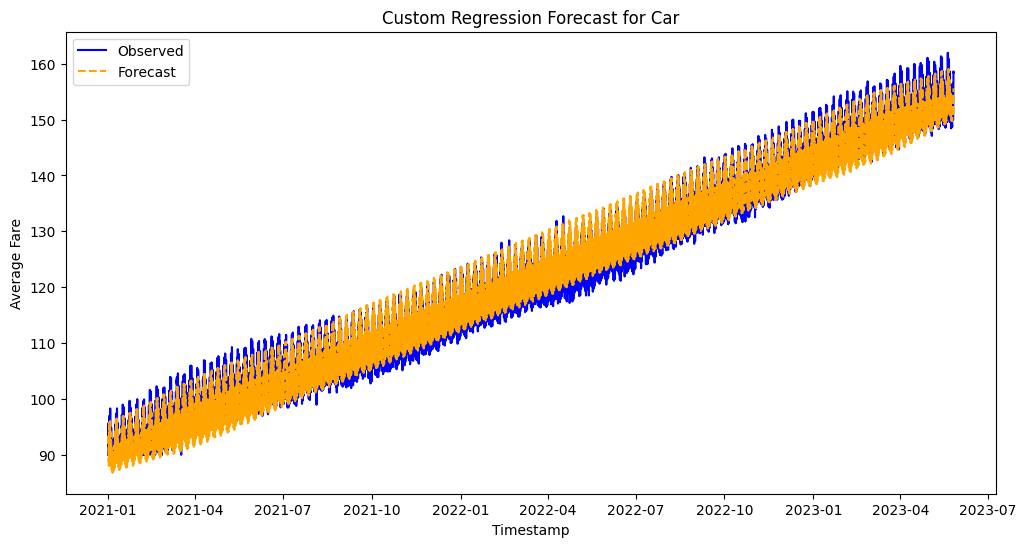

Model Summary:
R-squared: 0.9954
Mean Absolute Error (MAE): 1.0614
Mean Squared Error (MSE): 1.6156
Root Mean Squared Error (RMSE): 1.2710
0


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `pivoted_fares` DataFrame is already defined with 'car' column

# Prepare target variable and time index
car_target = pivoted_fares['car'].dropna()
time_index = np.arange(len(car_target))

# Difference the time series
car_diff = car_target.diff().dropna()

# Apply FFT
fft_result = np.fft.fft(car_diff)
fft_freq = np.fft.fftfreq(len(car_diff))

# Get magnitude of the FFT components
fft_magnitude = np.abs(fft_result)

# Identify significant frequencies (e.g., top 5)
num_significant = 75
indices = np.argsort(fft_magnitude)[-num_significant:]  # Indices of largest magnitudes
significant_frequencies = fft_freq[indices]
significant_coefficients = fft_result[indices]

# Function to create Fourier features for the significant frequencies
def fourier_features(t, significant_frequencies):
    features = []
    for freq in significant_frequencies:
        features.append(np.sin(2 * np.pi * freq * t))
        features.append(np.cos(2 * np.pi * freq * t))
    return np.column_stack(features)

# Create Fourier features for the significant frequencies
fourier_features_matrix = fourier_features(time_index, significant_frequencies)

# Create design matrix including the linear term
X_car = np.column_stack((time_index, fourier_features_matrix))

# Train custom regression model on the entire dataset
car_model = LinearRegression()
car_model.fit(X_car, car_target)

# Make predictions for the entire dataset
car_forecast_full = car_model.predict(X_car)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(car_target.index, car_target, label='Observed', color='blue')
plt.plot(car_target.index, car_forecast_full, label='Forecast', color='orange', linestyle='--')
plt.title('Custom Regression Forecast for Car')
plt.xlabel('Timestamp')
plt.ylabel('Average Fare')
plt.legend()
plt.show()

# Model summary
r_squared = car_model.score(X_car, car_target)
mae = mean_absolute_error(car_target, car_forecast_full)
mse = mean_squared_error(car_target, car_forecast_full)
rmse = np.sqrt(mse)

print(f"Model Summary:")
print(f"R-squared: {r_squared:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

print((time_index[0]))

**The above plot and model summary demonstrates the extent of the model's fit over the training data**

In [13]:
# Determine the length of the training set
N_train = len(pivoted_fares)

# Create a new time index for the test dataset
test_time_index = np.arange(N_train, N_train + len(pivoted_fares_test))

# Create Fourier features for the test dataset using the new time index
fourier_features_matrix_test = fourier_features(test_time_index, significant_frequencies)

# Create design matrix for the test dataset
X_car_test = np.column_stack((test_time_index, fourier_features_matrix_test))

# Make predictions using the trained model
car_predictions = car_model.predict(X_car_test)

# Create the output DataFrame
output = pd.DataFrame()

output['timestamp'] = pivoted_fares_test.index  # Ensure your test DataFrame has an index of timestamps
output['average_fare_car'] = car_predictions
# Display the output DataFrame
print(output.head())

            timestamp  average_fare_car
0 2023-05-26 05:00:00        156.367042
1 2023-05-26 06:00:00        156.772400
2 2023-05-26 07:00:00        157.106925
3 2023-05-26 08:00:00        157.228023
4 2023-05-26 09:00:00        157.113516


**The above code extracts the model's forecast over the testing data**

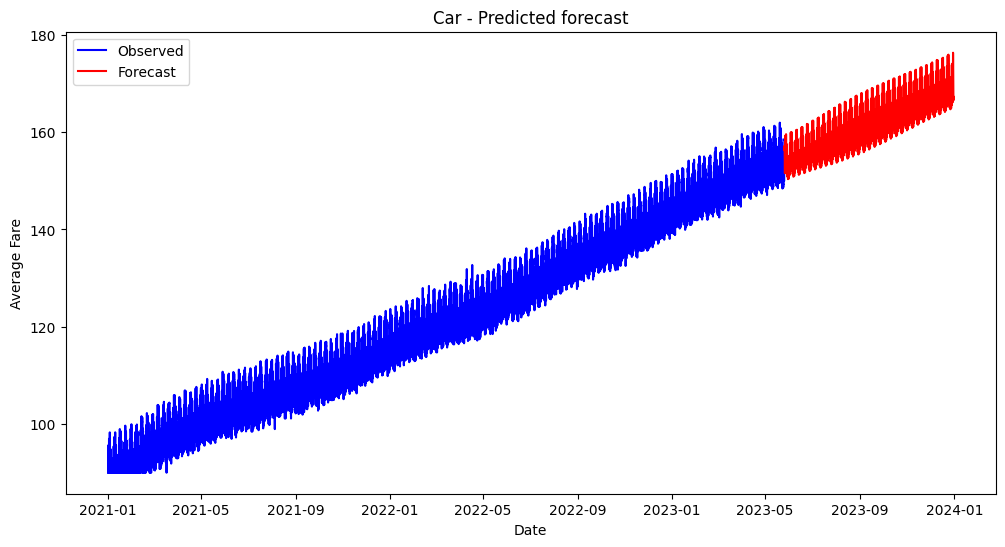

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(car_target.index, car_target, label="Observed", color="blue")
plt.plot(pivoted_fares_test.index, output['average_fare_car'], label="Forecast", color="red")
plt.title(f"Car - Predicted forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot demonstrate what the model forecast's after the training data**

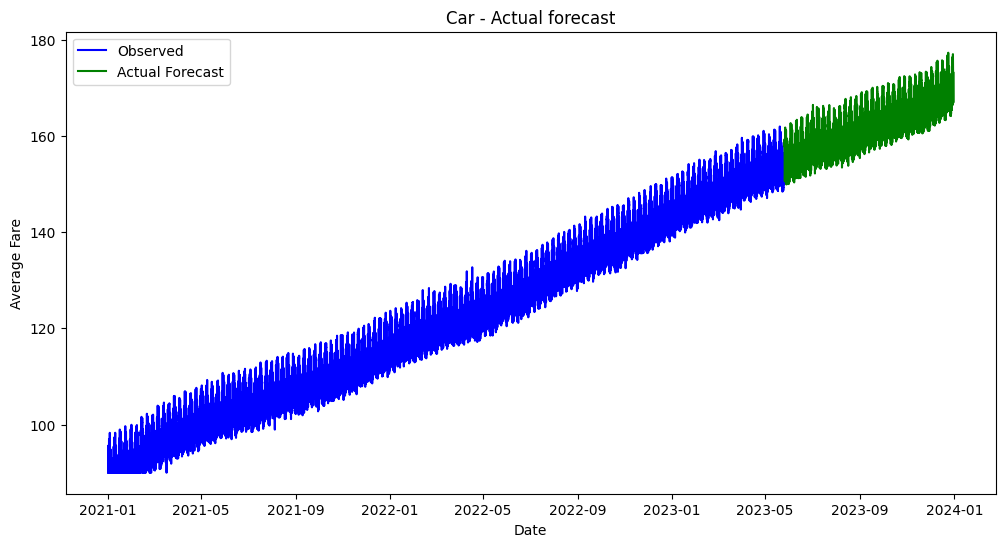

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(car_target.index, car_target, label="Observed", color="blue")
plt.plot(pivoted_fares_test.index,solution['average_fare_car'],label="Actual Forecast", color="green")
plt.title(f"Car - Actual forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot demonstrates the actual forecasts after the training data**

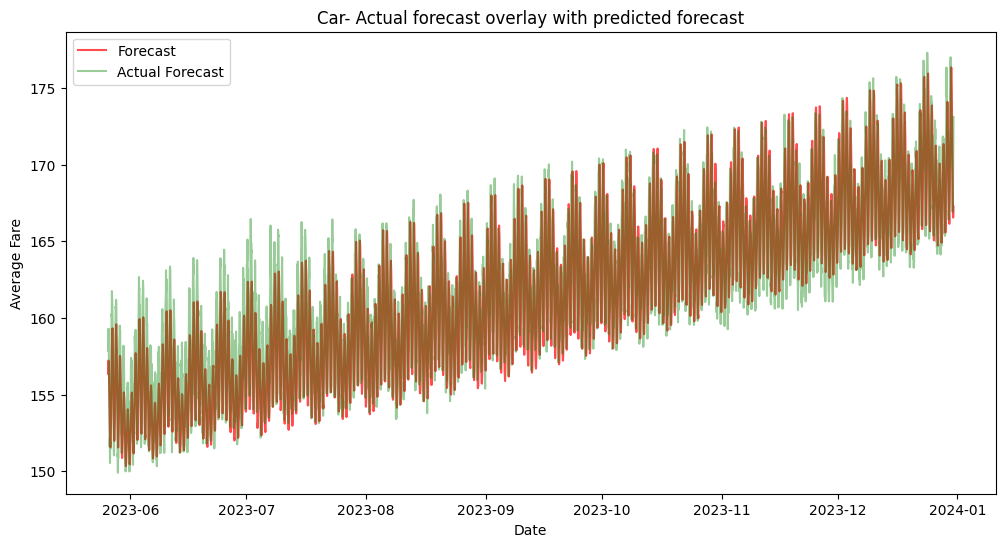

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(pivoted_fares_test.index, output['average_fare_car'], label="Forecast", color="red",alpha=0.7)
plt.plot(pivoted_fares_test.index,solution['average_fare_car'],label="Actual Forecast", color="green",alpha=0.4)
plt.title(f"Car- Actual forecast overlay with predicted forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot overlays the predictions by the model vs the actual correct forecasts**

In [18]:
from scipy import stats

residuals_car = solution['average_fare_car']-output['average_fare_car']
residuals_car = pd.DataFrame(residuals_car)

residuals_car_arr=np.array(residuals_car)

#summary of the residuals for car
residuals_car.describe()

,average_fare_car
count,5252.000000
mean,0.299720
std,2.879332
min,-6.901332
25%,-2.108866
50%,0.364397
75%,2.730953
max,8.387023


**The above code outputs the summay statistics of the residuals of the model**

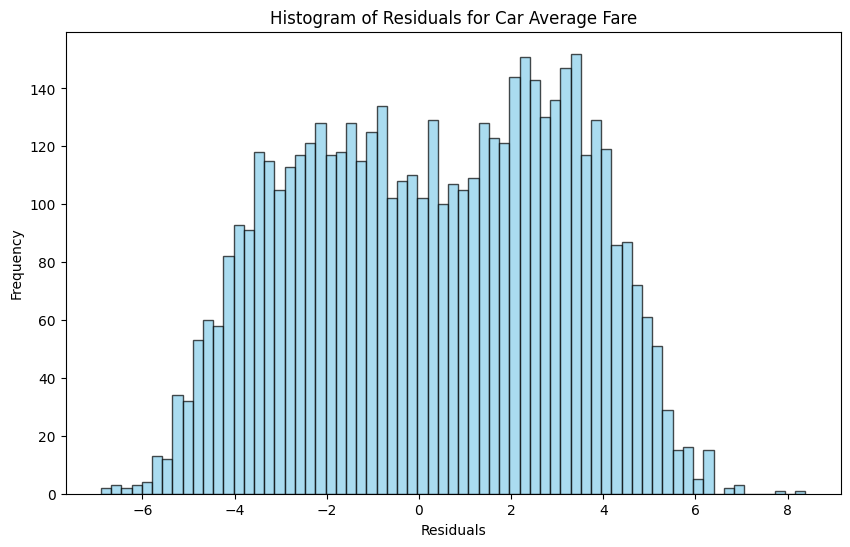

In [19]:
#Histogram of the residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(residuals_car, bins=69, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals for Car Average Fare")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


**The above plot is the histogram for the residuals**

In [20]:
#Shapiro-Wilk test for normality
shapiro_test_car = stats.shapiro(residuals_car_arr)
shapiro_p_value=shapiro_test_car.pvalue
print("Shapiro-Wilk Test:", shapiro_test_car.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_p_value)

# Interpretation of the Shapiro-Wilk test
if shapiro_p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H₀).")
else:
    print("Residuals do not appear to be normally distributed (reject H₀).")

Shapiro-Wilk Test: 0.9732658959952893
Shapiro-Wilk Test p-value: 2.9720004880724e-30
Residuals do not appear to be normally distributed (reject H₀).


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5252.
  res = hypotest_fun_out(*samples, **kwds)


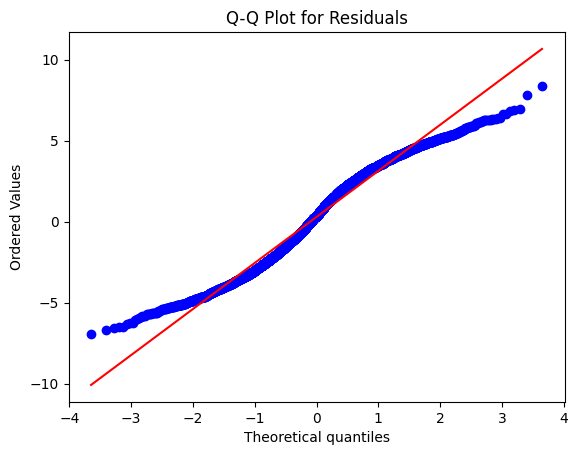

In [21]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Q-Q plot for residuals
stats.probplot(residuals_car_arr.flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot for Residuals")
plt.show()


In [22]:
from scipy.stats import skew, kurtosis

skewness = skew(residuals_car_arr)
kurt = kurtosis(residuals_car_arr)

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")


Skewness: [-0.07753402]
Kurtosis: [-1.03331524]


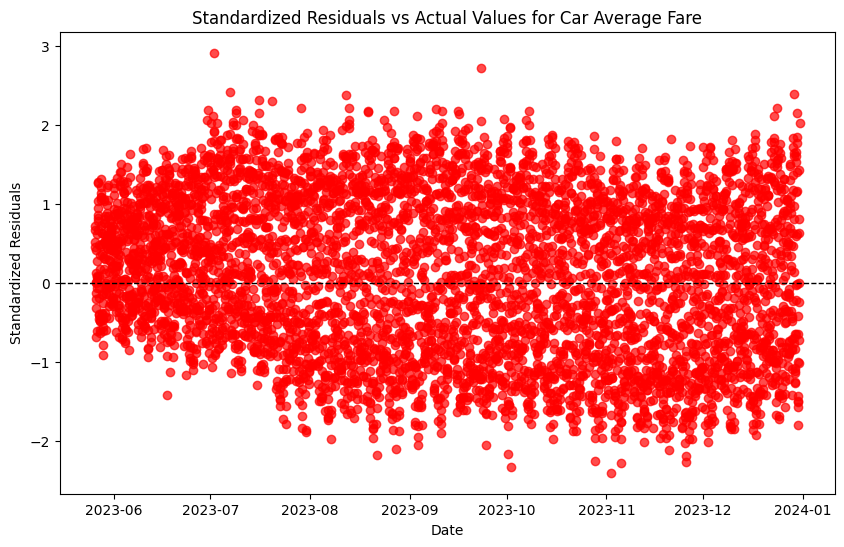

In [23]:
# Calculate the standardized residuals
standardized_residuals_car = residuals_car / residuals_car.std()

# Plot standardized residuals vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(pivoted_fares_test.index, standardized_residuals_car, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Zero line
plt.title("Standardized Residuals vs Actual Values for Car Average Fare")
plt.xlabel("Date")
plt.ylabel("Standardized Residuals")
plt.show()


In [24]:
#Test for stationarity of residuals
from statsmodels.tsa.stattools import adfuller
result = adfuller(residuals_car)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.327543585395294
p-value: 0.013691280775021873


In [25]:
#Test for autocorrelation of residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_car = acorr_ljungbox(residuals_car_arr, lags = 10)
print(ljungbox_car)

         lb_stat  lb_pvalue
1    4513.168999        0.0
2    8162.889260        0.0
3   10659.931583        0.0
4   11960.996518        0.0
5   12369.816641        0.0
6   12379.785939        0.0
7   12574.867147        0.0
8   13463.445403        0.0
9   15348.032011        0.0
10  18244.602056        0.0


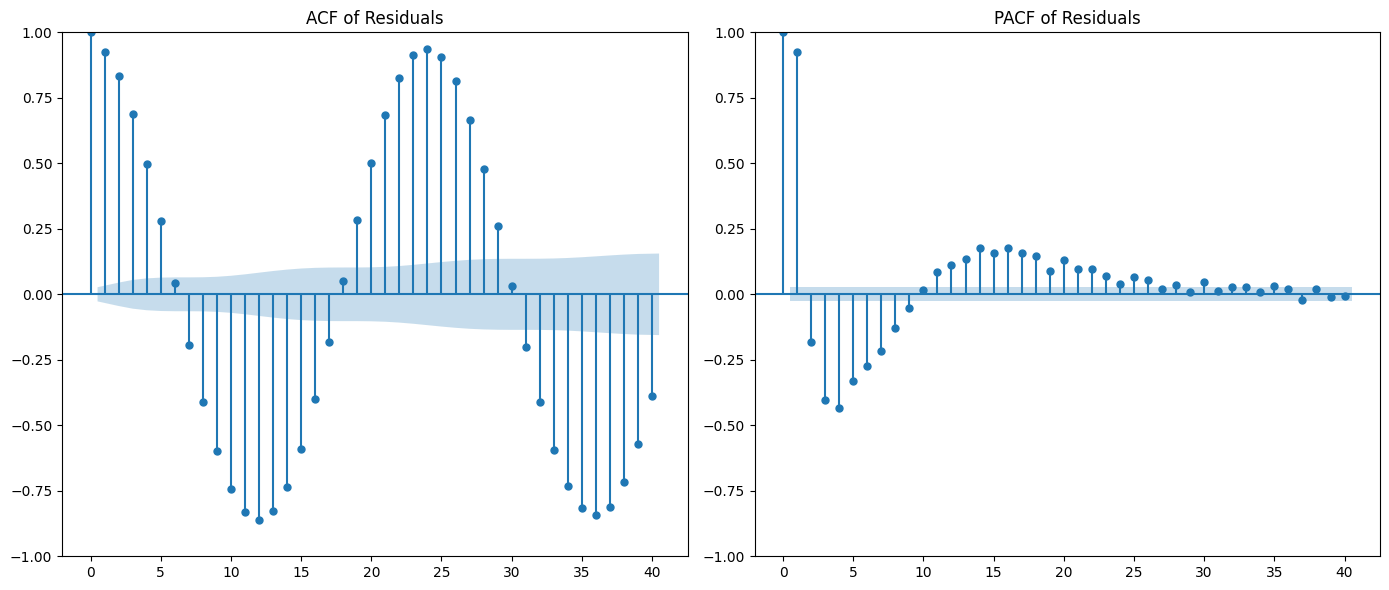

In [26]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot the ACF of the residuals
plt.subplot(121)
plot_acf(residuals_car, lags=40, ax=plt.gca(), alpha=0.05)  # 40 lags, 5% significance level
plt.title("ACF of Residuals")

# Plot the PACF of the residuals
plt.subplot(122)
plot_pacf(residuals_car, lags=40, ax=plt.gca(), alpha=0.05)  # 40 lags, 5% significance level
plt.title("PACF of Residuals")

# Display the plots
plt.tight_layout()
plt.show()

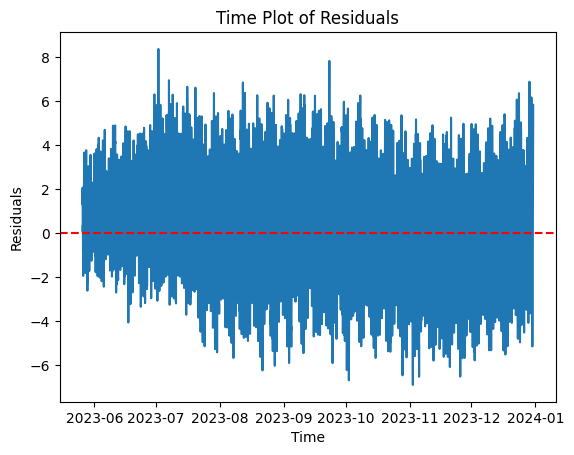

In [27]:
plt.plot(output['timestamp'], residuals_car)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Time Plot of Residuals")
plt.show()

# Residual Analysis Summary for Model 1

* It had a high R^2 value with respect to the training data, which means that it correctly explained the variance of the training data quite accurately.

* The residuals had a slightly positive mean of -0.03, this indicates that the model on average was underestimating the forecast.
* The residuals had a significant standard deviation nearing 3.
* The Shapiro-Wilk test for normality indicated that the residuals may not be normal
* The Q-Q plot of the residuals showed some deviation from the central line indicating non-normality
* The skewness of the residuals was nearly 0 indicating symmetry but the kurtosis was nearly -1 indicating light-tailed distribution
* The residual plots do not show any anomalies/heteroschedasticity
* The ADF test indicates that the residuals have trend stationarity
* The ljun-box test indicates that the residuals have signifant autocorrelation on nearly all lags.
* The ACF and PACF plots indicate that the model did not capture certain periodicity/seasonality
* The time plot confirms this (observe the seasonality)








# Patterns and Features Missed by the Model
1. **Temporal Patterns**

The significant Ljung-Box statistics across all lags suggest the model missed important temporal dependencies.

2. **Forecasting**

The model on average underestimates the actual forecast.
3. **Seasonality/Periodicity**

Based on the above tests and the residual-time plots, it is apparent that the model does not capture some of the seasonality/periodicity.

# About Model Applicability

It is supposed to be used whenever differencing the time series once eliminates the trend and preserves the periodicity.

**Limitations**

Model might not capture all patterns with top 75 frequencies or it may be too many and might capture noise also.

# What could have been done

1. Optimal number of fourier terms can be considered.
2. Possibly combine with another model to form an ensemble
3. Other methods could be used to remove the trend component of the data when training.

# Residual Analysis for Model 2 (Bike time series)
The model used was a **xgboost model with exogenous variables**.

*Note:*
*Total summary of the analysis for the model is at the end of the code corresponding to the current model.*

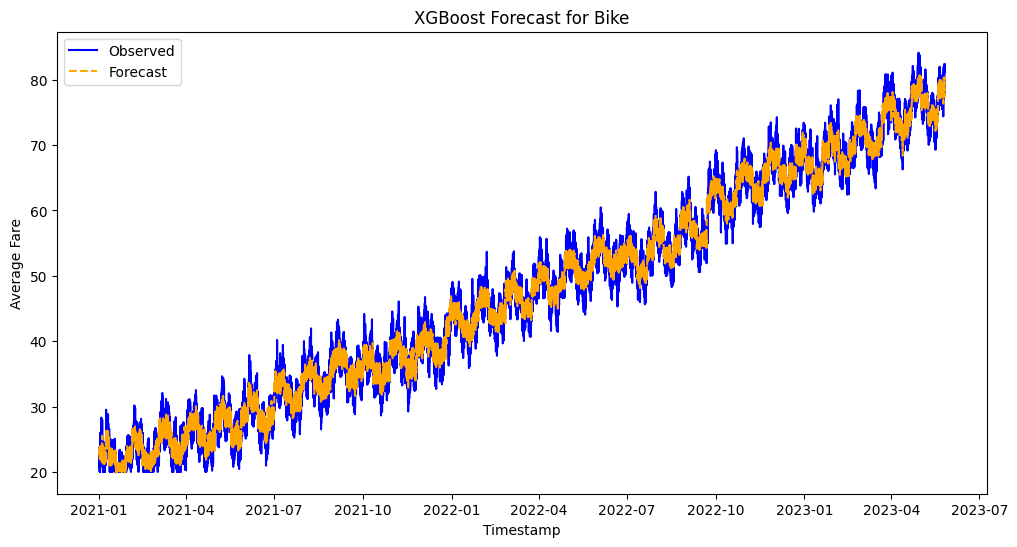

XGBoost Model Performance for Bike:
Mean Absolute Error (MAE): 1.3406
Mean Squared Error (MSE): 2.7820
Root Mean Squared Error (RMSE): 1.6679
R-squared: 0.9902
Max Predicted Fare: 80.687775


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming `pivoted_fares` DataFrame is already defined with 'bike', 'rides_completed', and 'driver_availability' columns

# Prepare the target variable
bike_target = pivoted_fares['bike'].dropna()  # Ensure there are no NaN values

# Prepare exogenous variables
exogenous_vars = pivoted_fares[['weather_Cloudy', 'weather_Rainy','weather_Stormy','rides_completed', 'driver_availability']].loc[bike_target.index]  # Align with bike_target

# Define time index for features
time_index = np.arange(len(bike_target))

# Create design matrix including the time index and exogenous variables
X_bike = np.column_stack((time_index, exogenous_vars))

# Train XGBoost model on the entire dataset
bike_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
bike_model.fit(X_bike, bike_target)

# Make predictions for the entire dataset
bike_forecast_full = bike_model.predict(X_bike)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(pivoted_fares.index, bike_target, label='Observed', color='blue')
plt.plot(pivoted_fares.index, bike_forecast_full, label='Forecast', color='orange', linestyle='--')
plt.title('XGBoost Forecast for Bike')
plt.xlabel('Timestamp')
plt.ylabel('Average Fare')
plt.legend()
plt.show()

# Print model performance metrics
mae = mean_absolute_error(bike_target, bike_forecast_full)
mse = mean_squared_error(bike_target, bike_forecast_full)
rmse = np.sqrt(mse)
r_squared = r2_score(bike_target, bike_forecast_full)

print(f'XGBoost Model Performance for Bike:')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared: {r_squared:.4f}')
print("Max Predicted Fare:", max(bike_forecast_full))

**The above plot and model summary demonstrates the extent of the model's fit over the training data**

In [30]:
# Prepare exogenous variables for the test dataset for the bike model
exogenous_vars_test = pivoted_fares_test[['weather_Cloudy', 'weather_Rainy', 'weather_Stormy',
                                           'rides_completed', 'driver_availability']]
# Create a new time index for the test dataset for the bike model, similar to the car model
test_time_index_bike = np.arange(N_train, N_train + len(exogenous_vars_test))
# Create design matrix for the test dataset for the bike model
X_bike_test = np.column_stack((test_time_index_bike, exogenous_vars_test))
# Make predictions using the trained bike model
bike_predictions = bike_model.predict(X_bike_test)
# Add bike predictions to the existing submission DataFrame
output['average_fare_bike'] = bike_predictions
# Display the updated submission DataFrame for both models
print(output.head())

            timestamp  average_fare_car  average_fare_bike
0 2023-05-26 05:00:00        156.367042          78.384117
1 2023-05-26 06:00:00        156.772400          78.123886
2 2023-05-26 07:00:00        157.106925          78.285301
3 2023-05-26 08:00:00        157.228023          78.865250
4 2023-05-26 09:00:00        157.113516          78.213997


**The above code extracts the model's forecast over the testing data**

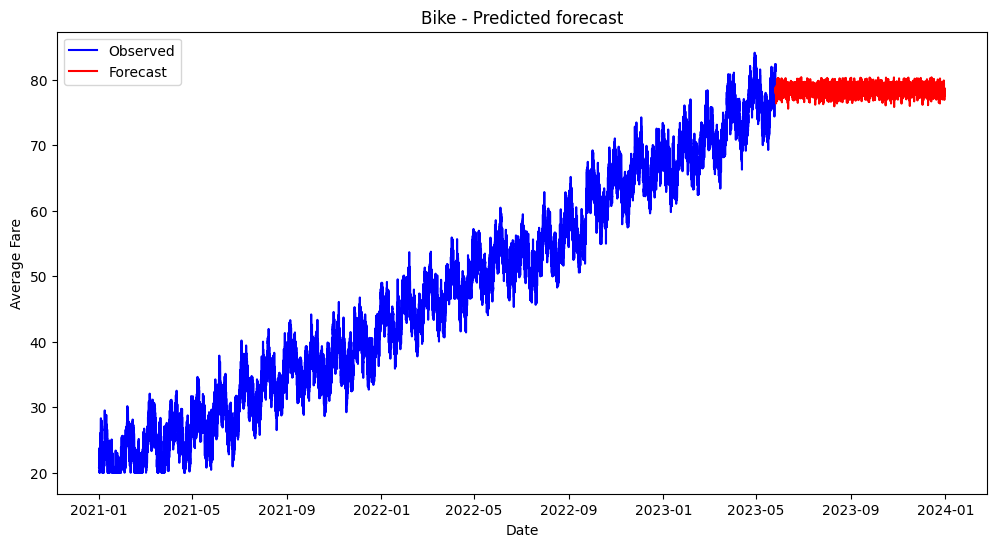

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(bike_target.index, bike_target, label="Observed", color="blue")
plt.plot(pivoted_fares_test.index, output['average_fare_bike'], label="Forecast", color="red")
plt.title(f"Bike - Predicted forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot demonstrate what the model forecast's after the training data**

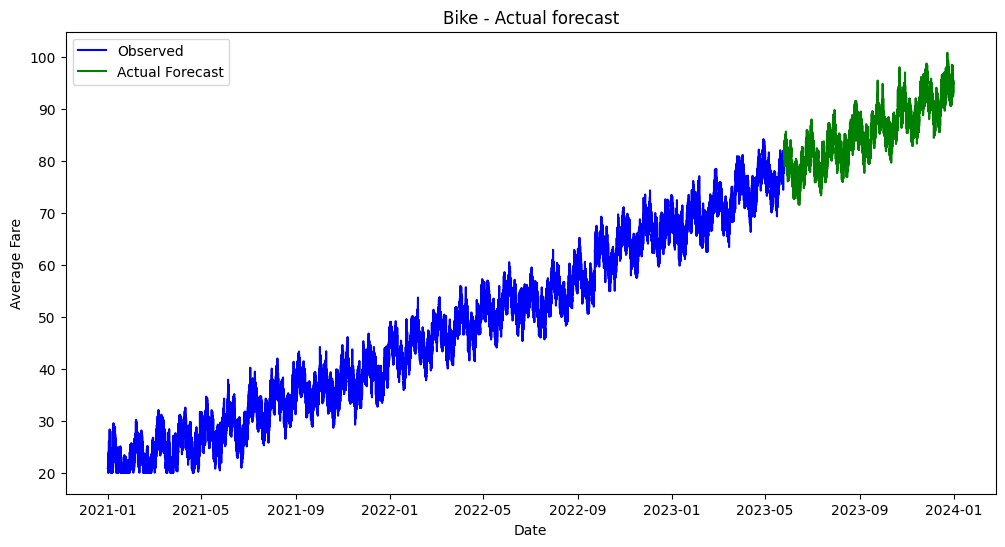

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(bike_target.index, bike_target, label="Observed", color="blue")
plt.plot(pivoted_fares_test.index,solution['average_fare_bike'],label="Actual Forecast", color="green")
plt.title(f"Bike - Actual forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot demonstrates the actual forecasts after the training data**

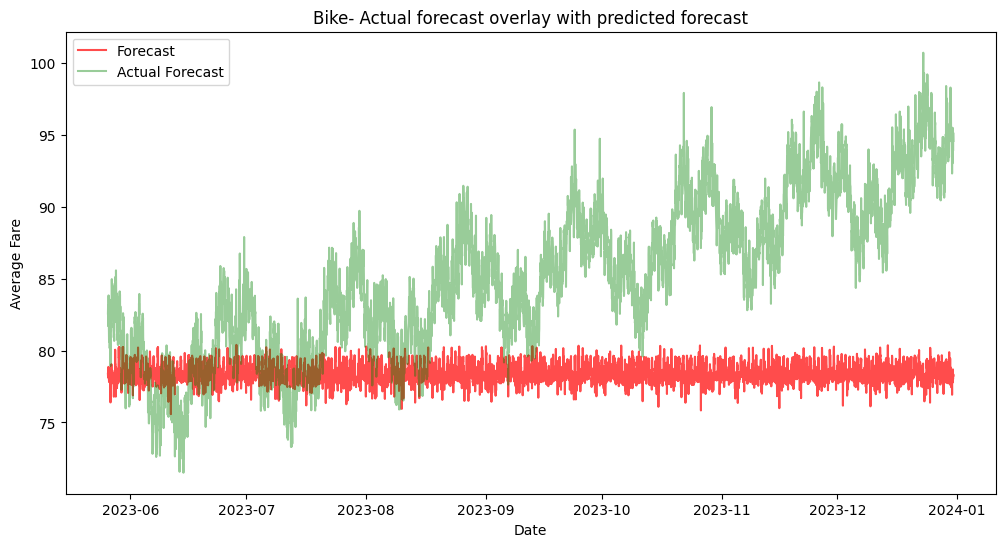

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(pivoted_fares_test.index, output['average_fare_bike'], label="Forecast", color="red",alpha=0.7)
plt.plot(pivoted_fares_test.index,solution['average_fare_bike'],label="Actual Forecast", color="green",alpha=0.4)
plt.title(f"Bike- Actual forecast overlay with predicted forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot overlays the predictions by the model vs the actual correct forecasts**

In [35]:
from scipy import stats

residuals_bike = solution['average_fare_bike']-output['average_fare_bike']
residuals_bike = pd.DataFrame(residuals_bike)

residuals_bike_arr=np.array(residuals_bike)

#summary of the residuals for bike
residuals_bike.describe()

,average_fare_bike
count,5252.000000
mean,6.932589
std,5.406857
min,-6.361904
25%,2.816699
50%,6.761493
75%,10.951258
max,23.200065


**The above code outputs the summay statistics of the residuals of the model**

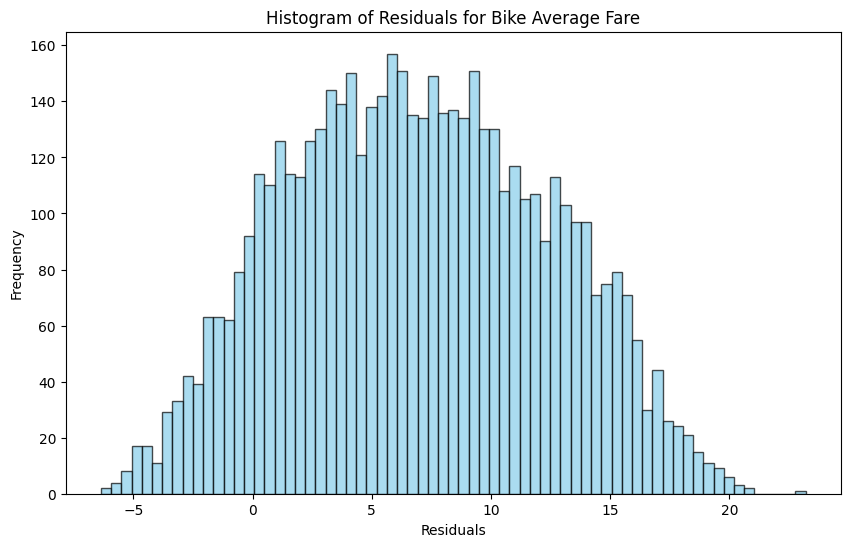

In [36]:
#Histogram of the residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(residuals_bike, bins=69, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals for Bike Average Fare")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


**The above plot is the histogram for the residuals**

In [37]:
#Shapiro-Wilk test for normality
shapiro_test_bike = stats.shapiro(residuals_bike_arr)
shapiro_p_value=shapiro_test_bike.pvalue
print("Shapiro-Wilk Test:", shapiro_test_bike.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_p_value)

# Interpretation of the Shapiro-Wilk test
if shapiro_p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H₀).")
else:
    print("Residuals do not appear to be normally distributed (reject H₀).")

Shapiro-Wilk Test: 0.9898838448055596
Shapiro-Wilk Test p-value: 5.954170262499577e-19
Residuals do not appear to be normally distributed (reject H₀).


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5252.
  res = hypotest_fun_out(*samples, **kwds)


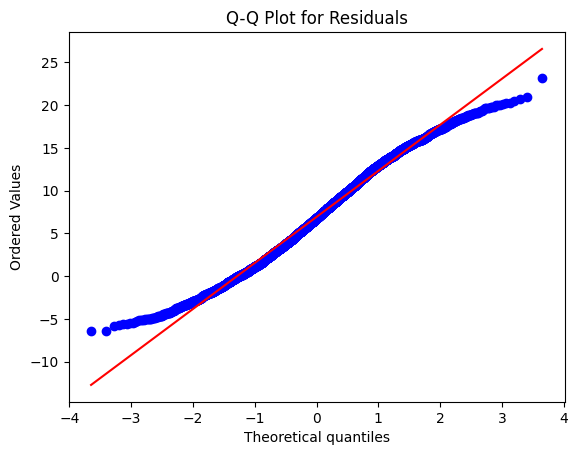

In [38]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Q-Q plot for residuals
stats.probplot(residuals_bike_arr.flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot for Residuals")
plt.show()


In [39]:
from scipy.stats import skew, kurtosis

skewness = skew(residuals_bike_arr)
kurt = kurtosis(residuals_bike_arr)

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")


Skewness: [0.07770319]
Kurtosis: [-0.71418482]


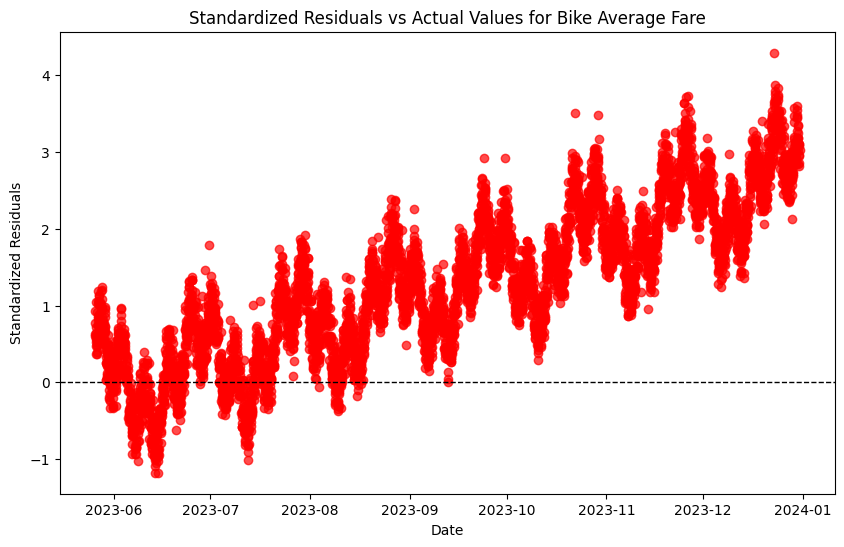

In [40]:
# Calculate the standardized residuals
standardized_residuals_bike = residuals_bike / residuals_bike.std()

# Plot standardized residuals vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(pivoted_fares_test.index, standardized_residuals_bike, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Zero line
plt.title("Standardized Residuals vs Actual Values for Bike Average Fare")
plt.xlabel("Date")
plt.ylabel("Standardized Residuals")
plt.show()


In [41]:
#Test for stationarity of residuals
from statsmodels.tsa.stattools import adfuller
result = adfuller(residuals_bike)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -4.690564734517843
p-value: 8.765511330537036e-05


In [42]:
#Test for autocorrelation of residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_bike = acorr_ljungbox(residuals_bike_arr, lags = 10)
print(ljungbox_bike)

         lb_stat  lb_pvalue
1    5050.668779        0.0
2   10060.808379        0.0
3   15016.027611        0.0
4   19896.077554        0.0
5   24693.046114        0.0
6   29409.560332        0.0
7   34045.456218        0.0
8   38606.730907        0.0
9   43098.167500        0.0
10  47530.402569        0.0


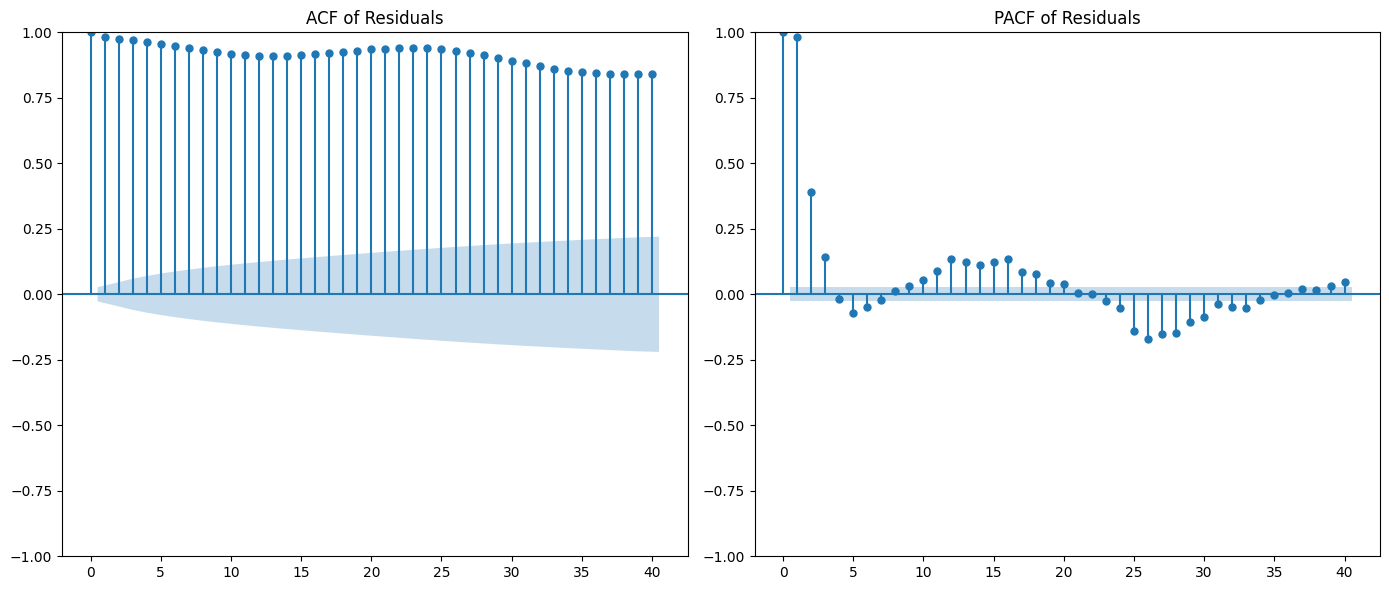

In [43]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot the ACF of the residuals
plt.subplot(121)
plot_acf(residuals_bike, lags=40, ax=plt.gca(), alpha=0.05)  # 40 lags, 5% significance level
plt.title("ACF of Residuals")

# Plot the PACF of the residuals
plt.subplot(122)
plot_pacf(residuals_bike, lags=40, ax=plt.gca(), alpha=0.05)  # 40 lags, 5% significance level
plt.title("PACF of Residuals")

# Display the plots
plt.tight_layout()
plt.show()

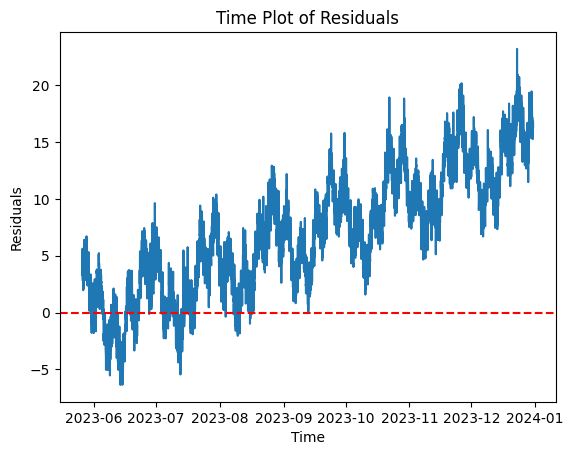

In [44]:
plt.plot(output['timestamp'], residuals_bike)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Time Plot of Residuals")
plt.show()

# Residual Analysis Summary for Model 2

* It had a high R^2 value with respect to the training data, which means that it correctly explained the variance of the training data quite accurately.

* The residuals had a high positive mean of nearly 6, this indicates that the model on average highly underestimating the forecast.
* The residuals had a significant standard deviation nearing 5.4.
* The Shapiro-Wilk test for normality indicated that the residuals may not be normal
* The Q-Q plot of the residuals showed small deviation from the central line indicating slight non-normality
* The skewness of the residuals was nearly 0 indicating symmetry but the kurtosis was nearly -0.7 indicating slightly light-tailed distribution
* The residual plots shows clear patterns/anomalies
* The ADF test indicates that the residuals have trend stationarity
* The ljun-box test indicates that the residuals have signifant autocorrelation on nearly all lags.
* The ACF and PACF plots indicate that the model did not capture certain periodicity/seasonality and trend components
* The time plot confirms this (observe the seasonality)


# Patterns and Features Missed by the Model
1. **Temporal Patterns**

The significant Ljung-Box statistics across all lags suggest the model missed important temporal dependencies.

2. **Forecasting**

The model on average underestimates the actual forecast.
3. **Seasonality/Periodicity**

Based on the above tests and the residual-time plots, it is apparent that the model does not capture some of the seasonality/periodicity.

# About Model Applicability

The model was intended to be used on time series data with exogenous data and non-linear behaviour

**Limitations**

Based on our implementation, it Ignores **temporal dependance** (considers all input output mappings as independant)


# What could have been done

The xgboost model did not understand the temporal significance of the data,

to fix this, we could have used advanced feature engineering techniques like:
1. Include temporal variables (like day of week, month etc)
2. Or Feed the model lagged values as new features
3. Also feed the lagged values of exogenous data

This gives the model temporal significance.





# Residual Analysis for Model 3 (Auto time series)
The model used was a **SARIMAX model** with the following parameters.
1. (p,d,q)=(0, 1, 1)
2. (P,D,Q,f)=(1, 0, 0, 24)
3. Exogenous variables

*Note:*
*Total summary of the analysis for the model is at the end of the code corresponding to the current model.*


Fitting SARIMAX model for Auto...


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


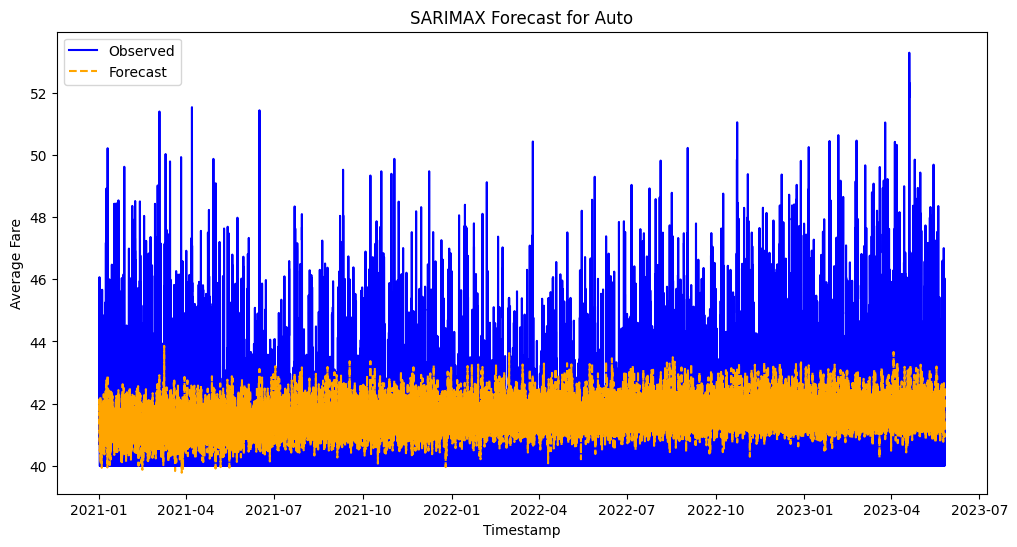

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Specify seasonal parameters for Auto
seasonal_order_auto = (1, 0, 0, 24)  # Adjust P, D, Q as needed

# Fit the SARIMAX model for Auto
print("\nFitting SARIMAX model for Auto...")

# Prepare the target variable
auto_target = pivoted_fares['auto'].dropna()  # Ensure there are no NaN values

# Prepare exogenous variables
exogenous_vars = pivoted_fares[['weather_Cloudy', 'weather_Rainy','weather_Stormy','rides_completed', 'driver_availability']].loc[auto_target.index]

# Fit the SARIMAX model using the entire dataset
model_auto = SARIMAX(
    auto_target,
    order=(0, 1, 1),  # Adjust as needed
    seasonal_order=seasonal_order_auto,
    exog=exogenous_vars  # Include exogenous variables
).fit(disp=False)

# Generate forecasts for the entire dataset
forecast_auto = model_auto.get_forecast(steps=len(auto_target), exog=exogenous_vars).predicted_mean

# Plot the forecast against the observed data
plt.figure(figsize=(12, 6))
plt.plot(auto_target.index, auto_target, label='Observed', color='blue')
plt.plot(auto_target.index, forecast_auto, label='Forecast', color='orange', linestyle='--')
plt.title('SARIMAX Forecast for Auto')
plt.xlabel('Timestamp')
plt.ylabel('Average Fare')
plt.legend()
plt.show()

# No predictions DataFrame created

**The above plot and model summary demonstrates the extent of the model's fit over the training data**

In [47]:
# Prepare exogenous variables for the test dataset
exogenous_vars_test = pivoted_fares_test[['weather_Cloudy', 'weather_Rainy', 'weather_Stormy',
                                           'rides_completed', 'driver_availability']]
# Generate forecasts using the trained SARIMAX model
forecast_auto_test = model_auto.get_forecast(steps=len(pivoted_fares_test), exog=exogenous_vars_test).predicted_mean
# Create the submission DataFrame
output['average_fare_auto'] = forecast_auto_test.values  # Unpack the forecast values
# Display the submission DataFrame
print(output.head())
print("Max Predicted Fare for Test (Auto):", max(output['average_fare_auto']))

            timestamp  average_fare_car  average_fare_bike  average_fare_auto
0 2023-05-26 05:00:00        156.367042          78.384117          42.118528
1 2023-05-26 06:00:00        156.772400          78.123886          41.867711
2 2023-05-26 07:00:00        157.106925          78.285301          41.747388
3 2023-05-26 08:00:00        157.228023          78.865250          42.226834
4 2023-05-26 09:00:00        157.113516          78.213997          43.317284
Max Predicted Fare for Test (Auto): 43.94458813560383


**The above code extracts the model's forecast over the testing data**

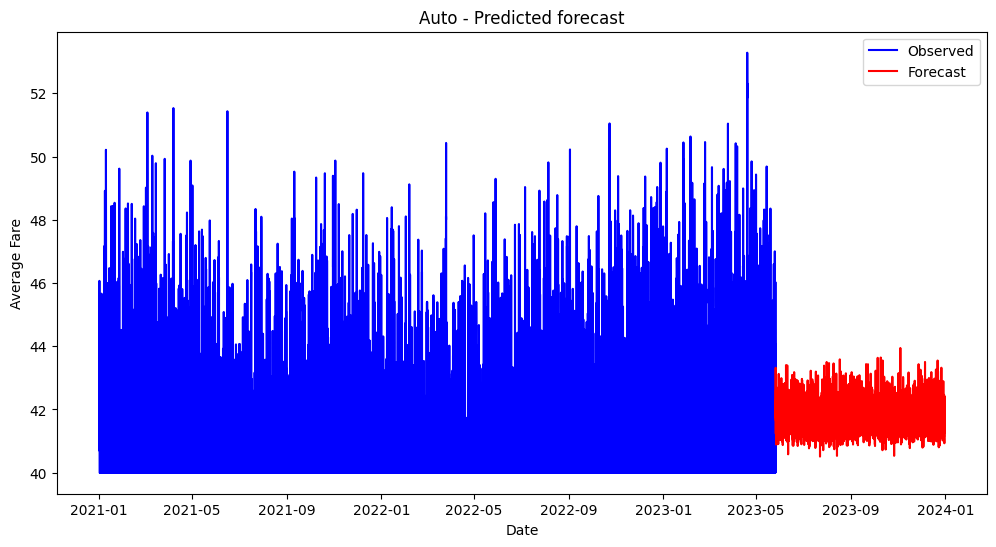

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(auto_target.index, auto_target, label="Observed", color="blue")
plt.plot(pivoted_fares_test.index, output['average_fare_auto'], label="Forecast", color="red")
plt.title(f"Auto - Predicted forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot demonstrate what the model forecast's after the training data**

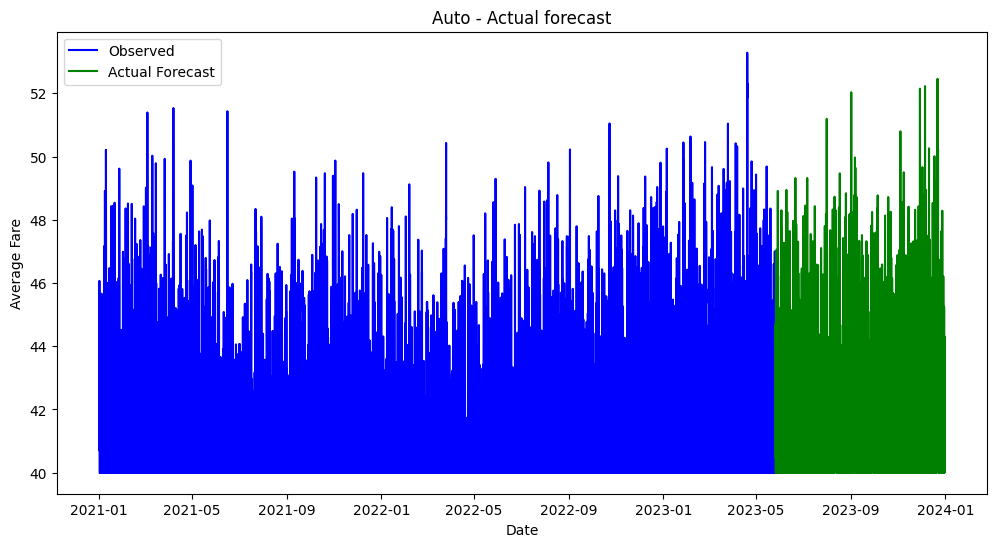

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(auto_target.index, auto_target, label="Observed", color="blue")
plt.plot(pivoted_fares_test.index,solution['average_fare_auto'],label="Actual Forecast", color="green")
plt.title(f"Auto - Actual forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot demonstrates the actual forecasts after the training data**

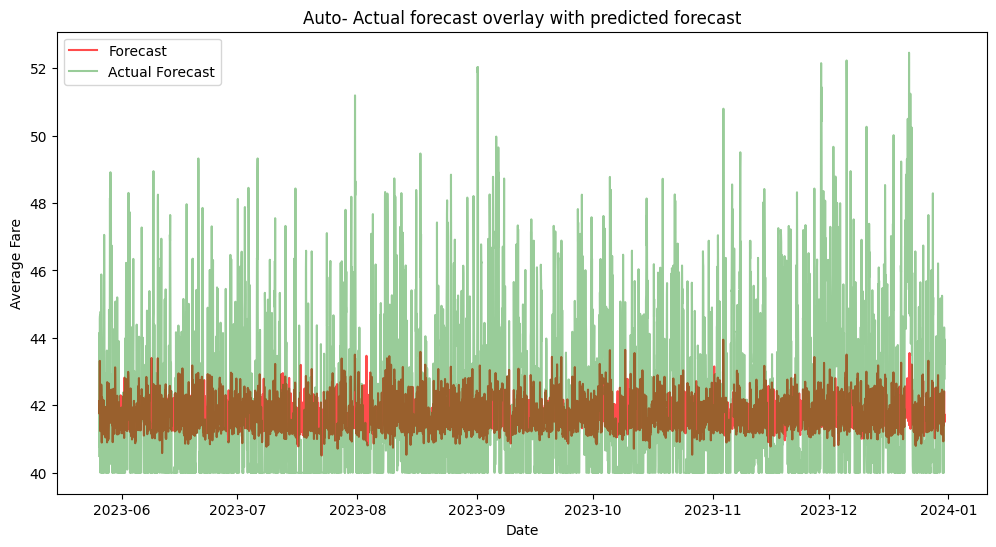

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(pivoted_fares_test.index, output['average_fare_auto'], label="Forecast", color="red",alpha=0.7)
plt.plot(pivoted_fares_test.index,solution['average_fare_auto'],label="Actual Forecast", color="green",alpha=0.4)
plt.title(f"Auto- Actual forecast overlay with predicted forecast")
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.legend()
plt.show()

**The above plot overlays the predictions by the model vs the actual correct forecasts**

In [51]:
from scipy import stats

residuals_auto =  solution['average_fare_auto']-output['average_fare_auto']
residuals_auto = pd.DataFrame(residuals_auto)

residuals_auto_arr=np.array(residuals_auto)

#summary of the residuals for auto
residuals_auto.describe()

,average_fare_auto
count,5252.000000
mean,0.262788
std,2.165086
min,-3.402669
25%,-1.392054
50%,-0.529016
75%,1.594199
max,10.495110


**The above code outputs the summay statistics of the residuals of the model**

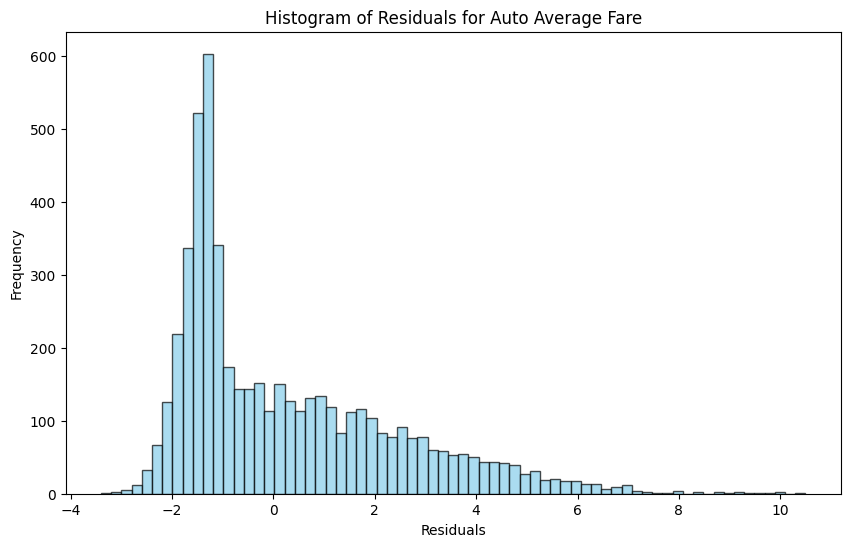

In [52]:
#Histogram of the residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(residuals_auto, bins=69, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals for Auto Average Fare")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


**The above plot is the histogram for the residuals**

In [53]:
#Shapiro-Wilk test for normality
shapiro_test_auto = stats.shapiro(residuals_auto_arr)
shapiro_p_value=shapiro_test_auto.pvalue
print("Shapiro-Wilk Test:", shapiro_test_auto.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_p_value)

# Interpretation of the Shapiro-Wilk test
if shapiro_p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H₀).")
else:
    print("Residuals do not appear to be normally distributed (reject H₀).")

Shapiro-Wilk Test: 0.8829841229860202
Shapiro-Wilk Test p-value: 8.355928013688628e-53
Residuals do not appear to be normally distributed (reject H₀).


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5252.
  res = hypotest_fun_out(*samples, **kwds)


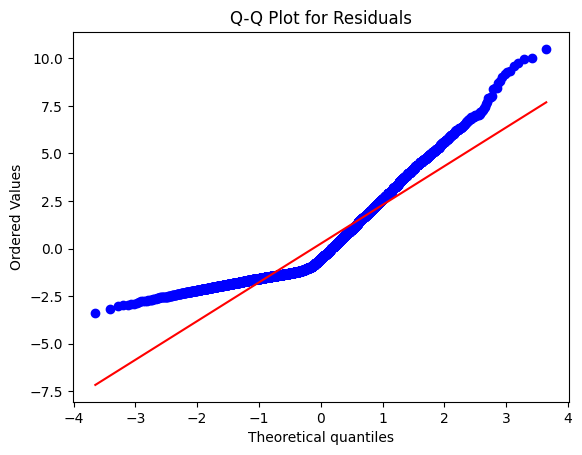

In [54]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Q-Q plot for residuals
stats.probplot(residuals_auto_arr.flatten(), dist="norm", plot=plt)
plt.title("Q-Q Plot for Residuals")
plt.show()


In [55]:
from scipy.stats import skew, kurtosis

skewness = skew(residuals_auto_arr)
kurt = kurtosis(residuals_auto_arr)

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")


Skewness: [1.13588384]
Kurtosis: [0.81032733]


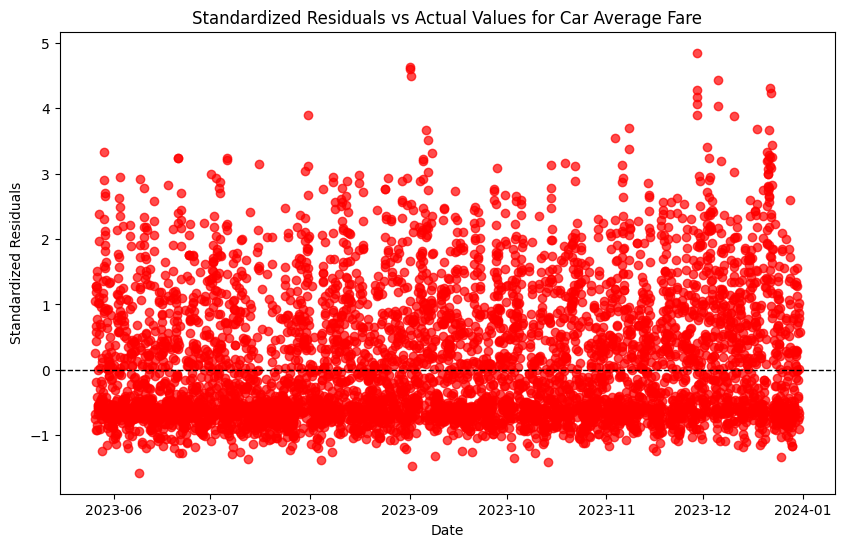

In [56]:
# Calculate the standardized residuals
standardized_residuals_auto = residuals_auto / residuals_auto.std()

# Plot standardized residuals vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(pivoted_fares_test.index, standardized_residuals_auto, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Zero line
plt.title("Standardized Residuals vs Actual Values for Car Average Fare")
plt.xlabel("Date")
plt.ylabel("Standardized Residuals")
plt.show()


In [57]:
#Test for stationarity of residuals
from statsmodels.tsa.stattools import adfuller
result = adfuller(residuals_auto)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -21.769341538492462
p-value: 0.0


In [58]:
#Test for autocorrelation of residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_auto = acorr_ljungbox(residuals_auto_arr, lags = 10)
print(ljungbox_auto)

        lb_stat  lb_pvalue
1   2859.787101        0.0
2   4294.463337        0.0
3   5027.549430        0.0
4   5442.120127        0.0
5   5698.017891        0.0
6   5849.123997        0.0
7   5942.019089        0.0
8   6002.620728        0.0
9   6041.746428        0.0
10  6076.102589        0.0


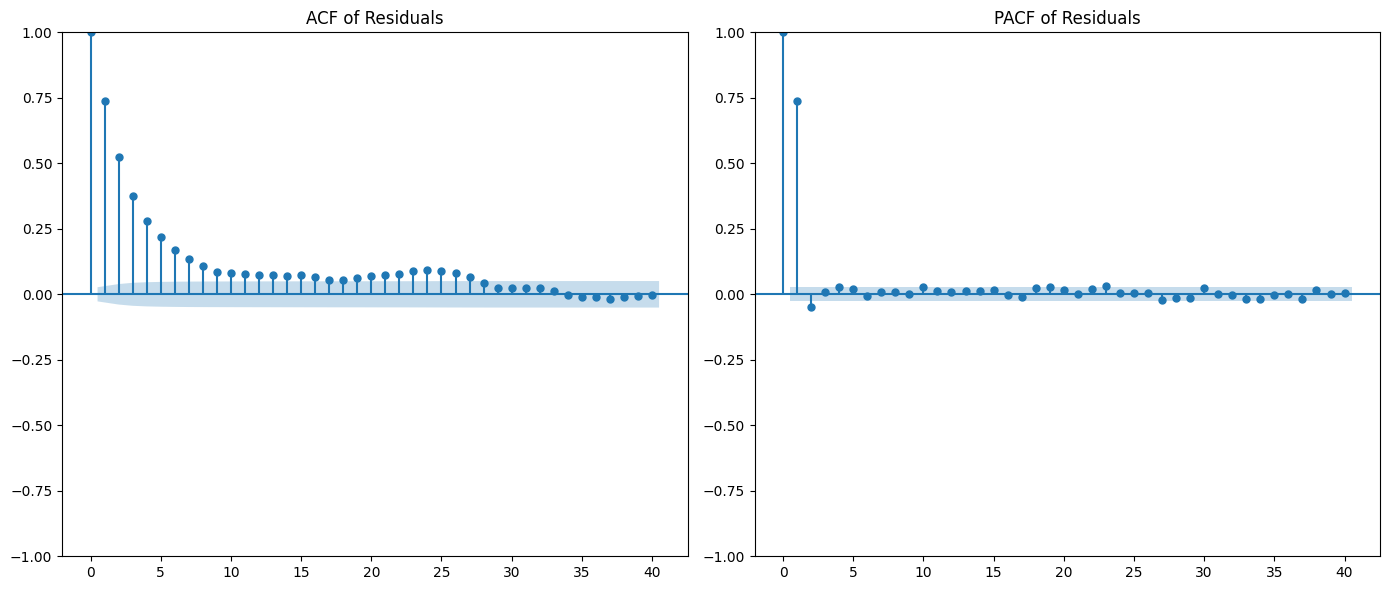

In [59]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot the ACF of the residuals
plt.subplot(121)
plot_acf(residuals_auto, lags=40, ax=plt.gca(), alpha=0.05)  # 40 lags, 5% significance level
plt.title("ACF of Residuals")

# Plot the PACF of the residuals
plt.subplot(122)
plot_pacf(residuals_auto, lags=40, ax=plt.gca(), alpha=0.05)  # 40 lags, 5% significance level
plt.title("PACF of Residuals")

# Display the plots
plt.tight_layout()
plt.show()

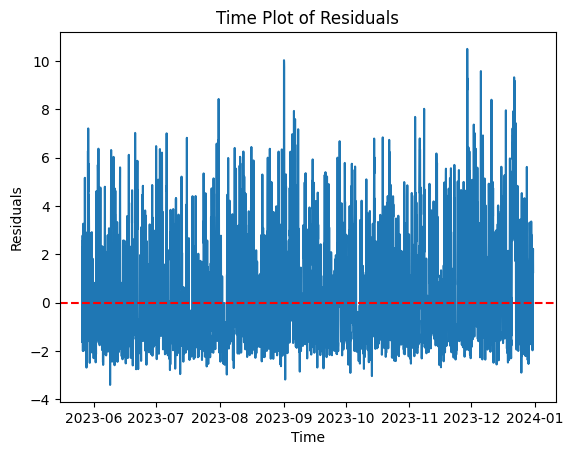

In [60]:
plt.plot(output['timestamp'], residuals_auto)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Time Plot of Residuals")
plt.show()

# Residual Analysis Summary for Model 3

# Patterns and Features Missed by the Model
1. **Temporal Patterns**

The significant Ljung-Box statistics across all lags suggest the model missed important temporal dependencies
The SARIMAX(0,1,1)(1,0,0,24) structure appears insufficient to capture:

Complex intraday patterns (beyond the 24-hour seasonality)
Possible weekly or monthly cycles
Long-term trend components



2. **Volatility Characteristics**

The non-normal distribution of residuals (skewness: 1.136, kurtosis: 0.810) indicates:

Unaccounted volatility clustering
Asymmetric response to price movements




3. **Extreme Values**

Looking at the plots:

The model struggles with extreme price spikes
There's systematic underestimation of peak values
Volatility is not uniformly captured across the time series

# Lessons Learned About the Data

**Complex Seasonality**

Single seasonal period (24) is insufficient
Multiple overlapping cycles present
Non-linear relationships between variables


**Volatility Structure**

Heteroscedastic behavior
Regime-dependent variance
Asymmetric price movements



# About Model Applicability

**SARIMAX Limitations**

Linear structure may be too restrictive
Single seasonal pattern insufficient
Assumes constant variance


**Future Modeling Considerations**

Need for more flexible model architectures
Importance of combining multiple approaches
Value of extensive feature engineering